## Rebalancing Design Pattern

The Rebalancing Design Pattern provides various approaches for handling datasets that are inherently imbalanced. By this we mean datasets where one label makes up the majority of the dataset, leaving far fewer examples of other labels.

In [0]:
import itertools
import math 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from google.cloud import bigquery

#### Downsampling

To demonstrate downsampling, we'll be using this [synthetic fraud detection](https://www.kaggle.com/ntnu-testimon/paysim1) dataset from Kaggle. We've made a version of it available in a public Cloud Storage bucket.

In [2]:
# Download the data and preview
!gsutil cp gs://ml-design-patterns/fraud_data_kaggle.csv .

Copying gs://ml-design-patterns/fraud_data_kaggle.csv...
- [1 files][470.7 MiB/470.7 MiB]                                                
Operation completed over 1 objects/470.7 MiB.                                    


In [3]:
fraud_data = pd.read_csv('fraud_data_kaggle.csv')
fraud_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [0]:
# Drop a few columns we won't use for this demo
fraud_data = fraud_data.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])
fraud_data = pd.get_dummies(fraud_data)

In [0]:
# Split into separate dataframes
fraud = fraud_data[fraud_data['isFraud'] == 1]
not_fraud = fraud_data[fraud_data['isFraud'] == 0]

# Take a random sample of non-fraud data
# The .005 frac will give us around an 80/20 split of not-fraud/fraud samples
# You can experiment with this value
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

In [0]:
# Put the data back together and shuffle
fraud_data = pd.concat([not_fraud_sample,fraud])
fraud_data = shuffle(fraud_data, random_state=2)

In [7]:
# Look at our data balance after downsampling
fraud_data['isFraud'].value_counts()

0    31772
1     8213
Name: isFraud, dtype: int64

In [0]:
train_test_split = int(len(fraud_data) * .8)

train_data = fraud_data[:train_test_split]
test_data = fraud_data[train_test_split:]

train_labels = train_data.pop('isFraud')
test_labels = test_data.pop('isFraud')

In [0]:
model = xgb.XGBRegressor(
    objective='reg:linear'
)

In [10]:
model.fit(train_data.values, train_labels)

[17:42:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
# Get some test predictions
y_pred = model.predict(test_data.values)

In [0]:
# To build a confusion matrix using the scikit utility, we'll need the values as ints
y_pred_formatted = []

for i in y_pred:
  y_pred_formatted.append(int(round(i)))

In [13]:
cm = confusion_matrix(test_labels.values, y_pred_formatted)
print(cm)

[[6360   43]
 [  82 1512]]


In [0]:
# This is from the sklearn docs
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

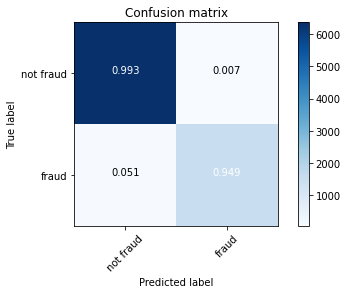

In [15]:
# With downsampling, our model's accuracy on fraud is almost as good as non-fraud examples
# You can compare this by training a model on the full dataset if you'd like (it'll take a long time to train given the size)
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

#### Weighted classes and output bias
To demonstrate weighted classes, we'll use a different fraud detection dataset in BigQuery. This one has far fewer minority class examples than the one used in the example above.

In [0]:
# To access BigQuery, you'll need to authenticate to your Cloud account
from google.colab import auth
auth.authenticate_user()

We'll take all of the fraud examples from this dataset, and a subset of non-fraud. Then we'll shuffle and combine and look at the number of examples we have for each class.

In [0]:
%%bigquery fraud_df --project sara-cloud-ml
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.ulb_fraud_detection`
WHERE Class = 1

In [0]:
# This query will take a a minute to run
%%bigquery nonfraud_df --project sara-cloud-ml
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.ulb_fraud_detection`
WHERE Class = 0
AND RAND() < 0.05

In [19]:
bq_fraud_data = pd.concat([fraud_df, nonfraud_df])
bq_fraud_data.sort_values(by=['Time'])
# bq_fraud_data = shuffle(bq_fraud_data, random_state=22)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
13869,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
3098,11.0,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,0.460230,-0.773657,0.323387,-0.011076,-0.178485,-0.655564,-0.199925,0.124005,-0.980496,-0.982916,-0.153197,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0
7017,41.0,1.138759,-1.192953,1.407131,-0.330070,-2.069503,-0.242175,-1.306635,0.104510,0.134628,0.493931,-0.895188,-0.182695,0.146081,-0.586611,0.797189,-0.891721,-0.079208,1.541588,-0.983586,-0.299307,-0.156198,-0.030569,-0.019723,0.433753,-0.029521,1.141241,-0.008612,0.041564,96.94,0
7868,41.0,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,-0.448937,-0.660863,-1.308522,0.788864,0.320294,0.295404,-0.287878,-0.451453,-1.011446,-0.191050,0.011106,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,34.13,0
4856,49.0,-0.549626,0.418949,1.729833,0.203065,-0.187012,0.253878,0.500894,0.251256,-0.227985,-0.576169,1.102032,0.823708,-0.569510,0.008710,-1.041414,-0.603403,0.225484,-0.352133,0.194946,0.016970,0.115062,0.418529,-0.065133,0.264981,0.003958,0.395969,0.027182,0.043506,59.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12815,172670.0,1.939795,-0.969791,-0.587017,-1.309403,-1.126185,-0.986735,-0.619530,-0.143709,2.387882,-0.995528,-0.736618,0.788915,0.061652,-0.149521,1.089282,-0.542341,-0.197894,0.215365,0.480936,-0.094239,0.285527,1.056616,0.023114,0.058599,-0.057562,-0.066172,0.031900,-0.035789,59.85,0
7239,172694.0,-0.816768,1.295381,-1.336395,-0.290017,0.877028,-0.639750,1.637290,0.031620,-1.334510,-1.075689,1.065118,0.716362,0.380555,-0.420083,-1.088048,-0.121209,0.858278,0.500646,0.601820,-0.052537,0.240530,0.615241,-0.269590,0.767657,0.139596,0.669905,-0.139549,0.060390,127.69,0
2852,172721.0,-0.947373,-0.059861,1.537605,0.117118,-0.315440,0.505595,0.342234,0.244829,-1.557720,0.613320,0.031953,-0.341449,-0.500256,0.216078,0.003889,-1.537024,-0.208283,2.281660,0.194544,0.086385,-0.239290,-0.367110,-0.034898,-0.561550,0.591367,-0.340983,0.310727,0.140940,138.00,0
8938,172744.0,-0.954967,1.114359,1.780434,-0.361532,-0.407570,-0.406413,0.210387,0.429851,-0.173493,-1.269369,-0.960160,0.459340,0.586295,0.101810,0.578975,0.046778,-0.214283,-0.004449,0.429980,-0.086966,-0.127048,-0.424787,-0.204041,0.025486,0.345074,-0.418458,-0.046577,0.014827,9.99,0


In [0]:
# Scale time and amount values
time_scaler = MinMaxScaler()
amt_scaler = MinMaxScaler()

bq_fraud_data['Time'] = time_scaler.fit_transform(bq_fraud_data['Time'].values.reshape(-1,1))
bq_fraud_data['Amount'] = amt_scaler.fit_transform(bq_fraud_data['Amount'].values.reshape(-1,1))

In [21]:
# See data balance
bq_fraud_data['Class'].value_counts()

0    14188
1      492
Name: Class, dtype: int64

In [0]:
train_test_split = int(len(bq_fraud_data) * .8)

train_data = bq_fraud_data[:train_test_split]
test_data = bq_fraud_data[train_test_split:]

train_labels = train_data.pop('Class')
test_labels = test_data.pop('Class')

In [0]:
# Create a tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels))
train_dataset = train_dataset.shuffle(len(train_data)).batch(1024)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data.values, test_labels))
test_dataset = test_dataset.shuffle(len(test_data)).batch(1)

Now let's try with weighted classes and add a bias initializer to our output layer. First, calculate the class weights.

In [0]:
# Get number of examples for each class from the training set
num_minority = train_labels.value_counts()[1]
num_majority = train_labels.value_counts()[0]

In [25]:
minority_class_weight = 1 / (num_minority / len(train_data)) / 2
majority_class_weight = 1 / (num_majority / len(train_data)) / 2

# Pass the weights to Keras in a dict
# The key is the index of each class
keras_class_weights = {0: majority_class_weight, 1: minority_class_weight}
print(keras_class_weights)

# Calculate output bias
output_bias = math.log(num_minority / num_majority)
print(output_bias)

{0: 0.5218627799502311, 1: 11.934959349593496}
-3.1298224531174395


In [0]:
fraud_model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(len(train_data.iloc[0]),), activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(output_bias))
])

In [0]:
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc_auc'),
]

In [0]:
fraud_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [0]:
fraud_model.fit(train_dataset, validation_data=test_dataset, epochs=10, class_weight=keras_class_weights)

#### Reframing: using cluster distance as a prediction signal

In this approach, train a clustering model and use the distance of new examples from clusters to detect anomalies. We'll train a kmeans model on the natality dataset to demonstrate this.

In [124]:
# This will take about a minute to run 
%%bigquery --project sara-cloud-ml
CREATE OR REPLACE MODEL
  `sara-cloud-ml.natality.baby_weight_clusters` OPTIONS(model_type='kmeans',
    num_clusters=4) AS
SELECT
  weight_pounds,
  mother_age,
  gestation_weeks
FROM
  `bigquery-public-data.samples.natality`
LIMIT 10000

""


First, let's look at the cluster prediction results for an "average" example from our dataset.

In [0]:
%%bigquery average_pred --project sara-cloud-ml
SELECT
  *
FROM
  ML.PREDICT (MODEL `sara-cloud-ml.natality.baby_weight_clusters`,
    (
    SELECT
      7.0 as weight_pounds,
      28 as mother_age,
      40 as gestation_weeks 
     )
  )

In [136]:
average_pred

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,weight_pounds,mother_age,gestation_weeks
0,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.764157285801...",7.0,28,40


Here, it's fairly obvious that this datapoint should be put in cluster 1, given the short distance from that cluster.

In [133]:
# Print the resulting cluster distances
df['NEAREST_CENTROIDS_DISTANCE'].iloc[0]

[{'CENTROID_ID': 1, 'DISTANCE': 0.7641572858019843},
 {'CENTROID_ID': 3, 'DISTANCE': 1.8753318107958212},
 {'CENTROID_ID': 2, 'DISTANCE': 2.443585441159741},
 {'CENTROID_ID': 4, 'DISTANCE': 3.529034745170229}]

Let's compare this with a cluster prediction for an outlier baby weight.

In [0]:
%%bigquery outlier_pred --project sara-cloud-ml
SELECT
  *
FROM
  ML.PREDICT (MODEL `sara-cloud-ml.natality.baby_weight_clusters`,
    (
    SELECT
      3.0 as weight_pounds,
      20 as mother_age,
      27 as gestation_weeks 
     )
  )

In [138]:
outlier_pred

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,weight_pounds,mother_age,gestation_weeks
0,3,"[{'CENTROID_ID': 3, 'DISTANCE': 3.726026043962...",3.0,20,27


Here there's a high distance from each cluster, which we can use to conclude that this might be an anomaly.

In [139]:
outlier_pred['NEAREST_CENTROIDS_DISTANCE'].iloc[0]

[{'CENTROID_ID': 3, 'DISTANCE': 3.726026043962655},
 {'CENTROID_ID': 1, 'DISTANCE': 3.8571677726904228},
 {'CENTROID_ID': 2, 'DISTANCE': 5.277867231738564},
 {'CENTROID_ID': 4, 'DISTANCE': 5.719630555422304}]

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License